# Capstone Project - The Battle of Neighborhoods

### Table of Contents
* [1. Introduction](#introduction)

* [2. Data Description](#data)

* [3. Methodology](#methodology)

* [4. Result](#result)

* [5. Discussion](#discussion)

* [6. Conclusion](#conclusion)

### 1. Introduction: Business Problem <a name="introduction"></a>

#### New York is one of my favorite cities in the world. There is so many kinds of restaurants, like Chinese food, American food, Portuguese cuisine, and etc. If you get tired of one kind, you can always find another brilliant one that suits your taste. In addition to a variety of types of food, restaurants of all levels can be found in NYC, from street food or breakfast truck to Michelin star restaurants. If you are a foodie, you will never get tired of this city. Therefore, I would like to choose NYC as the city to explore. 

In this project I will try to help Mr. Panini to find __an optimal location or block for his business__. Mr.Panini is an Italian restaurant owner in Califonia, and recently he would like to expand his business to NYC. He would like to open a new restaurant in Manhattan, but he doesn’t know where should him to set up his new business. 
Following is my strategy for Mr. Panini:   

1)	Since Mr. Panini is new to NYC, I will first __create a map of NYC and Manhattan__ to him. Given the map, he is supposed to have a big picture about what does NYC and Manhattan look like, how the venues distribute.  
 
2)	Mr.Panini is going to open an Italian restaurant. His main competitors are existed Italian restaurant. Therefore, I will __list all the Italian restaurant in Manhattan__ with their name, coordinates, rating.  

3)	In order to show a clear picture, I will create a map to show how Italian restaurants are distributed in each neighborhood.

4)	I will cluster the restaurants to __narrow down the location__ and __calculate the average rating__.   

5)	By choosing __the lowest average rating__ to be our target cluster, I will choose the neighborhood with __most Italian restaurants__. Comparison will make Mr.Panini’s restaurant stand out.  

6)	Finally, the location will be determined according to the Italian restaurants in this neighborhood.


### 2. Data Description <a name="data"></a>

The source of data is from New York data json file given by the course and from Foursquare API.   
   
1)	__New York data json__ file provides me with the borough, neighborhood, latitude and longitude of each neighborhood in NYC. This data source allows me to create the map of NYC and Manhattan.   
   
2)	__Foursquare API__ allows me to get the Venue in each neighborhood, its latitude, longitude, category, ID and rating. This data source allows me to obtain the list of Italian restaurants, conduct calculation of the rating, and create the map with Italian restaurants.

### 3. Methodology <a name="methodology"></a>
#### 1) Import package

In [3]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim #convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize #transform JSON file into a pandas dataframe

#!conda install -c conda-forge geocoder 
!pip install geocoder
import geocoder
#!conda install -c conda-forge googlemaps 
#take the coordinates and turn it into address
!pip install reverse_geocoder
!pip install pprint
import reverse_geocoder as rg  
import pprint 

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium #map rendering library

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


#### 2) Download and Explore dataset

First, download the New York data file

In [27]:
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
#with open('newyork_data.json') as json_data:
with open('C:\\Users\\xxiao\\Desktop\\nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [95]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Then, transfer the json file to a dataframe. I extract the features part of the data and create a dataframe with four columns: Borough, Neighborhood, Latitude, and Longitude.

In [28]:
neighborhoods_data = newyork_data['features']
#transform the data into a pandas dataframe
column_names = ['Borough','Neighborhood','Latitude','Longitude'] #define the columns 
neighborhoods = pd.DataFrame(columns=column_names)
#loop through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [101]:
neighborhoods.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


#### 3) Create a map of NYC

Let's visualize the data using the latitude and longitude of neighborhood in NYC.

In [29]:
# Use geopy library to get the latitude and longitude values of NYC
address = 'New York City, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of NYC are ({},{}).'.format(latitude,longitude))
# create a map of NYC 
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10) 
#add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'],neighborhoods['Longitude'],neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)
map_newyork

The geographical coordinate of NYC are (40.7127281,-74.0060152).


#### 4) Create a map of Manhattan

Now, let's focus on Manhattan. A map of Manhattan is shown below.

In [30]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True) #and reset the index
#get the geographical coordinates of Manhattan
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Manhattan are ({}, {}).'.format(latitude, longitude))
#visualize Manhattan
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
map_manhattan

The geographical coordinate of Manhattan are (40.7900869, -73.9598295).


In [31]:
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


#### 5) Use Foursquare API to explore all the Italian restaurants in Manhattan

In [63]:
CLIENT_ID =  'H5RIMC2UOZP540DYRKTGBG4QFYS1K3YLWUUD3SJUF0BXL4ET'# your Foursquare ID
CLIENT_SECRET = 'XALLI1SN5D1M2QPVH4THGOMU11OV1SV3AQFXDQ5ZBKVOKL52' # your Foursquare Secret
#'NHFQHQMUH1VO4TV454MHLWY2CDLPKRPT5RYWUGGZKNIHOR5D'
#'K5QXA24YRLK112ULQJYYQTWTSARX2TXLYFUQAL0XL2BG4RR3'
#'AZVI0RL0TF5C2T3PFFLUAGTGHUIDIAQ3RPBV32UHJ3F410F1'
#'JJHMYPYBE4KDWBWEDURZRYN2IJSDTHEGMTOWID1OCDQWL1GD'
#'II2QIVQFZJ3RB2FB3QDWSITOD0ZAAOJW0K1MZO2HOVSAVGJT'
#'CLDPTJ2VBEHDWPVQBD5QHYIDAWST2PWNPAHGPWNIODMK15GC'

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: H5RIMC2UOZP540DYRKTGBG4QFYS1K3YLWUUD3SJUF0BXL4ET
CLIENT_SECRET:XALLI1SN5D1M2QPVH4THGOMU11OV1SV3AQFXDQ5ZBKVOKL52


Using Foursquare API to extract the category of the venue

In [64]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Using Foursquare API to get the top 100 venues' name, latitude, longitude, category name, and ID in Manhattan.

In [65]:
# Create a function to get the top 100 venues that are in Manhattan within a radius of 500 meters
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            #lat, 
            #lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  #'Neighborhood Latitude', 
                  #'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

Now, show the dataframe of the above information.

In [66]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
manhattan_venues.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Marble Hill,Arturo's,40.874412,-73.910271,Pizza Place,4b4429abf964a52037f225e3
1,Marble Hill,Bikram Yoga,40.876844,-73.906204,Yoga Studio,4baf59e8f964a520a6f93be3
2,Marble Hill,Tibbett Diner,40.880404,-73.908937,Diner,4b79cc46f964a520c5122fe3
3,Marble Hill,Starbucks,40.877531,-73.905582,Coffee Shop,55f81cd2498ee903149fcc64
4,Marble Hill,Dunkin',40.877136,-73.906666,Donut Shop,4b5357adf964a520319827e3


In [67]:
# manhattan_venues.groupby('Venue Category').count()

Let's focus on the Italian restaurants only. Therefore, I filter the above dataframe to get the data with category of Italian Restaurant.

In [68]:
manhattan_italian = manhattan_venues[manhattan_venues['Venue Category'] == 'Italian Restaurant'].reset_index(drop=True) 
manhattan_italian.head()
#anhattan_italian.groupby('Neighborhood').count()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Chinatown,Bacaro,40.714468,-73.991589,Italian Restaurant,472a027af964a520ea4b1fe3
1,Washington Heights,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant,4d21107c6e8c37042b58ff9f
2,Hamilton Heights,Fumo,40.821412,-73.950499,Italian Restaurant,56d8e01d498ef1500ae7fbfe
3,Manhattanville,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,457f1183f964a5204b3f1fe3
4,Manhattanville,Bettolona,40.814084,-73.959574,Italian Restaurant,4c956003f7cfa1cd2e2ebd15


In [69]:
# Can be deleted
venue_id = '3fd66200f964a520bfe31ee3'
VERSION = '20180605' 
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
print(url)
results = requests.get(url).json
print(results)

https://api.foursquare.com/v2/venues/3fd66200f964a520bfe31ee3?client_id=H5RIMC2UOZP540DYRKTGBG4QFYS1K3YLWUUD3SJUF0BXL4ET&client_secret=XALLI1SN5D1M2QPVH4THGOMU11OV1SV3AQFXDQ5ZBKVOKL52&v=20180605
<bound method Response.json of <Response [200]>>


#### 6) Use Foursquare to acquire ratings for each restaurant

Rating is an important measurement and criterion in my project. Hence, I use Foursquare API to get the rating of each italian restaurant in Manhattan.

In [70]:
# create a function to get the rating for each venue
def getRating(names, venue_id):
    rate_list = []
    for name, vid in zip(names, venue_id):
        #create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            vid,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        result = requests.get(url).json()['response']
        try:
            rate_list.append(result['venue']['rating']) 
        except:
            rate_list.append('This venue has not been rated yet.')
    rates = pd.DataFrame(rate_list)
    rates.columns = ['Rating']
    return(rates)

In [71]:
# get the rating for each Italian restaurant
rating = getRating(manhattan_italian['Venue'],manhattan_italian['Venue ID'])
rating.head()

,Rating
0,8.2
1,8.6
2,8.9
3,9.1
4,8.0


Let's combine the rating with previous dataframe.

In [72]:
# Merge rating and previous data
italian_merged = manhattan_italian
italian_merged['Rating'] = rating
italian_merged

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Rating
0,Chinatown,Bacaro,40.714468,-73.991589,Italian Restaurant,472a027af964a520ea4b1fe3,8.2
1,Washington Heights,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant,4d21107c6e8c37042b58ff9f,8.6
2,Hamilton Heights,Fumo,40.821412,-73.950499,Italian Restaurant,56d8e01d498ef1500ae7fbfe,8.9
3,Manhattanville,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,457f1183f964a5204b3f1fe3,9.1
4,Manhattanville,Bettolona,40.814084,-73.959574,Italian Restaurant,4c956003f7cfa1cd2e2ebd15,8.0
5,Upper East Side,Sant Ambroeus Madison Ave,40.775328,-73.962819,Italian Restaurant,4a22d7f9f964a520977d1fe3,8.7
6,Upper East Side,Antonucci,40.775711,-73.956607,Italian Restaurant,4b3bedfaf964a5209e7e25e3,8.5
7,Upper East Side,Parma Restaurant,40.774930,-73.957210,Italian Restaurant,4ab972d6f964a520697f20e3,8.1
8,Upper East Side,Sistina,40.777716,-73.961668,Italian Restaurant,57d9ddfe498e8a66d21ce8bb,7.5
9,Upper East Side,Caffe Buon Gusto - Manhattan,40.772498,-73.956994,Italian Restaurant,4a6133a6f964a52015c21fe3,8.7


#### 7) Visualize the Italian restaurants in Manhattan

In order to show how the italian restaurant in Manhattan distributed. I visualize the italian restaurants in Manhattan and mark every italian restaurants. When click each circle, a pop with restaurant's name can be seen.

In [73]:
#get the geographical coordinates of Manhattan
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Manhattan are ({}, {}).'.format(latitude, longitude))

The geographical coordinate of Manhattan are (40.7900869, -73.9598295).


In [74]:
# visualize Manhattan
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers(italian restaurant) to map
for lat, lng, label in zip(italian_merged['Venue Latitude'], italian_merged['Venue Longitude'], italian_merged['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='coral',
        fill=True,
        fill_color='coral',
        fill_opacity=0.5,
        parse_html=False).add_to(map_manhattan)  
map_manhattan

#### 8) Using *k*-means for Restaurant Segmentation

A method to narrow down the location is through segment and clustering. I used the *k*-means clustering with k=5 to do the cluster. Then, calculate the average restaurant rating in each cluster. I will choose the cluster with the lowest rating. The reason is simple that people tend to try a new restaurant when they find the rating of others are pretty low. It is easier for Mr. Panini's restaurant to get a higher rating.

In [75]:
italian_merged.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Rating
0,Chinatown,Bacaro,40.714468,-73.991589,Italian Restaurant,472a027af964a520ea4b1fe3,8.2
1,Washington Heights,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant,4d21107c6e8c37042b58ff9f,8.6
2,Hamilton Heights,Fumo,40.821412,-73.950499,Italian Restaurant,56d8e01d498ef1500ae7fbfe,8.9
3,Manhattanville,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,457f1183f964a5204b3f1fe3,9.1
4,Manhattanville,Bettolona,40.814084,-73.959574,Italian Restaurant,4c956003f7cfa1cd2e2ebd15,8.0


In [76]:
#Pre-processing data for cluster
#First, I normalize the dataset. Since the categorical variables is not meaningful for discrete variables
#dorp this feature and run clustering
df = italian_merged.drop(['Neighborhood','Venue','Venue Category','Venue ID'], axis=1)
df.head()

,Venue Latitude,Venue Longitude,Rating
0,40.714468,-73.991589,8.2
1,40.851423,-73.939761,8.6
2,40.821412,-73.950499,8.9
3,40.814015,-73.960266,9.1
4,40.814084,-73.959574,8.0


In [77]:
from sklearn.preprocessing import StandardScaler
X = df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset[0:5]

array([[-1.25642409, -0.34453112, -0.45753365],
       [ 3.72713456,  2.27969614,  0.45032839],
       [ 2.63509961,  1.73601521,  1.13122492],
       [ 2.36594077,  1.24147729,  1.58515594],
       [ 2.36844042,  1.27649949, -0.91146466]])

In [78]:
# run model into 5 clusters
kcluster = 5
k_means = KMeans(n_clusters = kcluster, random_state=0).fit(cluster_dataset) #run k-means clustering
labels = k_means.labels_

Now, I add the label to the previous dataframe.

In [79]:
italian_merged['Label'] = labels
italian_merged

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Rating,Label
0,Chinatown,Bacaro,40.714468,-73.991589,Italian Restaurant,472a027af964a520ea4b1fe3,8.2,0
1,Washington Heights,Saggio Restaurant,40.851423,-73.939761,Italian Restaurant,4d21107c6e8c37042b58ff9f,8.6,1
2,Hamilton Heights,Fumo,40.821412,-73.950499,Italian Restaurant,56d8e01d498ef1500ae7fbfe,8.9,1
3,Manhattanville,Pisticci Ristorante,40.814015,-73.960266,Italian Restaurant,457f1183f964a5204b3f1fe3,9.1,1
4,Manhattanville,Bettolona,40.814084,-73.959574,Italian Restaurant,4c956003f7cfa1cd2e2ebd15,8.0,4
5,Upper East Side,Sant Ambroeus Madison Ave,40.775328,-73.962819,Italian Restaurant,4a22d7f9f964a520977d1fe3,8.7,1
6,Upper East Side,Antonucci,40.775711,-73.956607,Italian Restaurant,4b3bedfaf964a5209e7e25e3,8.5,1
7,Upper East Side,Parma Restaurant,40.774930,-73.957210,Italian Restaurant,4ab972d6f964a520697f20e3,8.1,4
8,Upper East Side,Sistina,40.777716,-73.961668,Italian Restaurant,57d9ddfe498e8a66d21ce8bb,7.5,4
9,Upper East Side,Caffe Buon Gusto - Manhattan,40.772498,-73.956994,Italian Restaurant,4a6133a6f964a52015c21fe3,8.7,1


#### 9) Visualize the resulting clusters

Now, let's visualize the clusters with five different colors.

In [102]:
#create map
map_cluster = folium.Map(location=[latitude,longitude],zoom_start=11)
#set color scheme for the clusters
x = np.arange(kcluster)
ys = [i+x+(i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#add markers to the map
markers_colors = []
for v, lat, lon, poi, cluster in zip(italian_merged['Venue'],italian_merged['Venue Latitude'],italian_merged['Venue Longitude'],italian_merged['Neighborhood'], italian_merged['Label']):
    label = folium.Popup(v+' in '+str(poi)+', ''Cluster '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster)
map_cluster

#### Examine Clusters

Following, I would like to calculate the average rating of each cluster, and then the result will tell us what cluster has the lowest average rating.

In [81]:
#Four clusters
cluster_1 = italian_merged.loc[italian_merged['Label']==0, italian_merged.columns[[0,1] + list(range(6, 8))]]
cluster_2 = italian_merged.loc[italian_merged['Label']==1, italian_merged.columns[[0,1] + list(range(6, 8))]]
cluster_3 = italian_merged.loc[italian_merged['Label']==2, italian_merged.columns[[0,1] + list(range(6, 8))]]
cluster_4 = italian_merged.loc[italian_merged['Label']==3, italian_merged.columns[[0,1] + list(range(6, 8))]]
cluster_5 = italian_merged.loc[italian_merged['Label']==4, italian_merged.columns[[0,1] + list(range(6, 8))]]
avg_rating = {'cluster 1': cluster_1['Rating'].mean(), 'cluster 2': cluster_2['Rating'].mean(),
              'cluster 3': cluster_3['Rating'].mean(), 'cluster 4': cluster_4['Rating'].mean(),
              'cluster 5': cluster_5['Rating'].mean()}

In [103]:
# Get the cluster with minimun rating
min_rating = [(key,value) for (key,value) in avg_rating.items() if value== min(avg_rating.values())]
print('The cluster with lowest rating is: ', min_rating[0][0], min_rating[0][1])

The cluster with lowest rating is:  Upper East Side 7.8199999999999985


#### Explore neighborhood
In this section, I am going to foucs on a single area to decide where to set up a new business. In order to do this, I have following steps:  
1.Get a list include all italian restaurants and their prices  
2.Use bar chart to show the number of Italian restaurants and try to decide the neighborhood to set up business.

#### 1) Get the list of all Italian Restaurants in this cluster

Since I already narrows down the area to cluster five, now I will list all the italian restaurants in cluster five.

In [113]:
cluster = italian_merged.loc[italian_merged['Label']==4,italian_merged.columns[0:7]]
cluster.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Rating
4,Manhattanville,Bettolona,40.814084,-73.959574,Italian Restaurant,4c956003f7cfa1cd2e2ebd15,8.0
7,Upper East Side,Parma Restaurant,40.774930,-73.957210,Italian Restaurant,4ab972d6f964a520697f20e3,8.1
8,Upper East Side,Sistina,40.777716,-73.961668,Italian Restaurant,57d9ddfe498e8a66d21ce8bb,7.5
10,Upper East Side,Caffe Grazie,40.779538,-73.959986,Italian Restaurant,4b23ee1ef964a520255d24e3,8.2
11,Upper East Side,Quattro Gatti Ristorante,40.775449,-73.955977,Italian Restaurant,4b5260e2f964a520587a27e3,7.8


#### 2) Analyze each neighborhood

In [84]:
# Get the frequency of each neighborhood and restaurant
cluster_onehot = pd.get_dummies(cluster[['Venue']],prefix='',prefix_sep='')
cluster_onehot['Neighborhood'] = cluster['Neighborhood']
fixed_columns = [cluster_onehot.columns[-1]]+list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
cluster_onehot = cluster_onehot.groupby('Neighborhood').mean().reset_index().reset_index(drop=True)
cluster_onehot = cluster_onehot.set_index('Neighborhood')
cluster_onehot.head()

,Bella Blu,Bella Luna,Bettolona,Caffe Grazie,Campagnola Restaurant,Cibo E Vino,Da Raffaele,Delizia 73 Ristorante & Pizza,Il Postino,Isle of Capri,Joanne Trattoria,Lex Restaurant,Luna Rossa,Mezzaluna Restaurants,Mimi's Italian Restaurant & Piano Bar,Nino's,Noi Due,Parma Restaurant,Quattro Gatti Ristorante,Sfoglia,Sistina,Tiramisu
Neighborhood,,,,,,,,,,,,,,,,,,,,,,
Carnegie Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
Lenox Hill,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
Lincoln Square,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
Manhattanville,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sutton Place,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, I can sum up the number of restaurants in the each neighborhood in cluster five

In [85]:
# Get the number of restaurants in each neighborhood
neighborhood_num = cluster.groupby('Neighborhood').count()
neighborhood_num = pd.DataFrame(neighborhood_num['Venue'])
neighborhood_num = neighborhood_num.reset_index()
neighborhood_num

,Neighborhood,Venue
0,Carnegie Hill,2
1,Lenox Hill,5
2,Lincoln Square,2
3,Manhattanville,1
4,Sutton Place,1
5,Turtle Bay,3
6,Upper East Side,5
7,Upper West Side,2
8,Yorkville,1


Now, a bar chart is helpful to make decision.

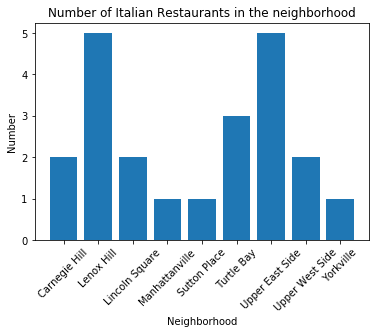

In [94]:
# plot bar chart to show the number of restaurants
import matplotlib.pyplot as plt
plt.bar(neighborhood_num['Neighborhood'], neighborhood_num['Venue'])
plt.title('Number of Italian Restaurants in the neighborhood')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45)
plt.ylabel('Number')
plt.show()

Since my strategy is first locate the cluster with lowest rate, and then choose a neighborhood with the highest number of restaurants.   
Now, I will focus on Lenox Hill and Upper East Side. Since they hace the same number of Italian restaurant, then I will choose the neighborhood with lower average rating.  

In [114]:
lenox_hill = cluster[cluster['Neighborhood']=='Lenox Hill']
upper_east_side = cluster[cluster['Neighborhood']=='Upper East Side']
avg_rating = {'Lenox Hill': lenox_hill['Rating'].mean(), 'Upper East Side': upper_east_side['Rating'].mean()}
min_rating = [(key,value) for (key,value) in avg_rating.items() if value== min(avg_rating.values())]
print('The neighborhood with lowest rating is: ', min_rating[0][0])
upper_east_side = upper_east_side.reset_index(drop=True)

The neighborhood with lowest rating is:  Upper East Side


#### Create a map to show Italian restaurants in Upper East Side

In [91]:
#create map
address = 'Upper East Side, New York City, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_ues = folium.Map(location=[latitude,longitude],zoom_start=15)
#add markers to the map
markers_colors = []
for v, lat, lon, rate in zip(upper_east_side['Venue'],upper_east_side['Venue Latitude'],upper_east_side['Venue Longitude'], upper_east_side['Rating']):
    label = folium.Popup(v+', '+str(rate), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=7,
        popup=label,
        color='violet',
        fill=True,
        fill_color='violet',
        fill_opacity=0.8).add_to(map_ues)
map_ues

Now, I can get our target latitude and longitude by calculating the mean of five coordinates

In [93]:
lat_mean = upper_east_side['Venue Latitude'].mean()
lon_mean = upper_east_side['Venue Longitude'].mean()
print('The center of five restaurants is (',lat_mean,lon_mean,')')

The center of five restaurants is ( 40.77651589506405 -73.95835456693234 )


In [90]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates) 
      
    # result is a list containing ordered dictionary. 
    pprint.pprint(result)  
  
# Driver function 
if __name__=="__main__": 
      
    # Coorinates tuple.Can contain more than one pair. 
    coordinates =(lat_mean, lon_mean) 
      
    reverseGeocode(coordinates)  

[OrderedDict([('lat', '40.78343'),
              ('lon', '-73.96625'),
              ('name', 'Manhattan'),
              ('admin1', 'New York'),
              ('admin2', 'New York County'),
              ('cc', 'US')])]


### 4. Result <a name="result"></a>

The address I get is 1187 Lexington Avenue, New York, NY 10028, United States of America is the optimal location to open a new Italian restaurant for Mr. Panini. 

### 5. Discussion <a name="discussion"></a>

The location I would like to provide with Mr.Panini is __1187 Lexington Avenue__. Main reasons are:  

(1) __Manhattan__ is the most popular borough in NYC, with the highest density and a variety of restaurants. Mr.Panini's restaurant can benefit from large population and demand.   

(2) I saperate Manhattan into five clusters using __k-mean method__ to figure out the average rating in each cluster. The restaurants at this Neighborhood have average lowest rating. When people are surrounded by low rating restaurants, people would tend to choose the new one. As long as the new restaurant can offer tasty dishes, it is highly likely that the new one can receive higher rating. 
    
(3) When I look inside the cluster, I have to decide to build in which neighborhood. The method I used is to compare the number of restaurants in each neighborhood. Therefore, I narrow down __Lenox Hill__ and __Upper East Side__ because they have more restaurants than other neighborhoods. However, Upper East Side has lower rating. When people conduct comparing, Mr.Panini's restaurant can stand out. 
  
It is undoubtful that other factors, such as __other type of restaurants, the price, population distribution and etc__, should be considered. However, according to the methods I have learned from this course, 1187 Lexington Avenue would be the one I recommend. This address now is a La Marqueza Beauty Spa.

### 6. Conclusion <a name="conclusion"></a>

THe purpose of this project is to help Mr. Panini find an optimal location to move his business from California to New York. Thanks for __Cousera__ capstone project provides me with NYC data file so I can easily get the coordinates of neighborhood and borough in NYC. Through data from Foursquare API, I am able to cluster the italian restaurants into five cluster and calculate the average rating. Clustering helps me to narrow down the area. This project determine the optimal location only based on the competitors category, locations and ratings.   
   
For Mr.Panini, he is supposed to consider more factors include price, other type of restaurants, food quality, menu, population density, real estate availability and etc. 